# **1.Selection**

In [2]:
# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset from the specified path (note the space in the folder name)
import pandas as pd

PATH = "/content/drive/MyDrive/Breast Cancer-Dataset/data.csv"
df = pd.read_csv(PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:10], "..." if len(df.columns) > 10 else "")
df.head(3)


Shape: (569, 33)
Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean'] ...


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [4]:
# Infer target column and clean obvious junk
import numpy as np

df = df.copy()

# Drop unnamed/junk columns if present
junk_cols = [c for c in df.columns if str(c).lower().startswith("unnamed")]
if junk_cols:
    df.drop(columns=junk_cols, inplace=True)

# Prefer 'diagnosis', else 'target'/'label' (case-insensitive)
cands = {c.lower(): c for c in df.columns}
target_col = None
for key in ("diagnosis", "target", "label"):
    if key in cands:
        target_col = cands[key]
        break

if target_col is None:
    raise ValueError("Could not infer target column. Expected one of: diagnosis/target/label.")

# Map textual labels to binary if needed: M→1 (malignant/positive), B→0 (benign/negative)
y_raw = df[target_col]
if y_raw.dtype == object:
    mapping = {
        "M": 1, "B": 0,
        "malignant": 1, "benign": 0
    }
    y = y_raw.str.strip().str.lower().map(mapping).astype("Int64")
    # recover capital M/B mapping
    if y.isna().any():
        alt_map = {"M": 1, "B": 0}
        y = y_raw.map(alt_map).astype("Int64")
    if y.isna().any():
        raise ValueError("Label mapping failed. Inspect unique target values: %s" % y_raw.unique())
else:
    # Assume already binary 0/1
    y = y_raw.astype(int)

# Sanity check: binary
vals = pd.Series(y.unique()).dropna().sort_values().tolist()
if not (len(vals) == 2 and set(vals) <= {0, 1}):
    raise ValueError(f"Target must be binary 0/1 after mapping; got: {vals}")

# Identify obvious non-features (id-like)
non_features = [c for c in df.columns if "id" in str(c).lower()]
if target_col not in non_features:
    non_features.append(target_col)

# Numeric features only
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [c for c in num_cols if c not in non_features]

print("Target column:", target_col)
print("Non-features dropped:", non_features)
print("Number of candidate features:", len(FEATURES))
print("First 8 features:", FEATURES[:8])


Target column: diagnosis
Non-features dropped: ['id', 'diagnosis']
Number of candidate features: 30
First 8 features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']


In [5]:
# Freeze contract variables for downstream stages
TARGET = target_col
X = df[FEATURES].copy()
y = y.astype(int)

# Basic diagnostics
print("X shape:", X.shape, "| y length:", len(y))
print("\nClass balance (counts):")
print(y.value_counts().rename({1: "malignant(1)", 0: "benign(0)"}))
print("\nClass balance (proportions):")
print(y.value_counts(normalize=True).round(3).rename({1: "malignant(1)", 0: "benign(0)"}))

# NA snapshot
na_feat = X.isna().sum()
na_in_any = int((na_feat > 0).sum())
print(f"\nFeatures with missing values: {na_in_any} / {X.shape[1]}")
if na_in_any:
    display(na_feat[na_feat > 0].sort_values(ascending=False).head(10))

# Ethical note (kept concise and explicit)
print("\nEthical note: Prioritize minimizing false negatives (missed malignant cases), "
      "acknowledge dataset limits and potential bias, and avoid overclaiming clinical utility.")


X shape: (569, 30) | y length: 569

Class balance (counts):
diagnosis
benign(0)       357
malignant(1)    212
Name: count, dtype: int64

Class balance (proportions):
diagnosis
benign(0)       0.627
malignant(1)    0.373
Name: proportion, dtype: float64

Features with missing values: 0 / 30

Ethical note: Prioritize minimizing false negatives (missed malignant cases), acknowledge dataset limits and potential bias, and avoid overclaiming clinical utility.


# **2.Preprocessing**

In [6]:
# Stratified train/val/test split with fixed seed (60/20/20 overall)
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# 1) Hold out test set (20% of full data)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# 2) Split the remaining 80% into train (75% of 80% = 60% total) and val (25% of 80% = 20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=RANDOM_STATE
)

# Freeze split contract for downstream stages
SPLITS = {
    "train": (X_train, y_train),
    "val":   (X_val,   y_val),
    "test":  (X_test,  y_test),
}

print("Split complete.")


Split complete.


In [7]:
import pandas as pd
import numpy as np

def summarize_split(name, X_s, y_s):
    print(f"\n[{name.upper()}] n={len(y_s)} | features={X_s.shape[1]}")
    vc = y_s.value_counts().rename({1: "malignant(1)", 0: "benign(0)"})
    vp = y_s.value_counts(normalize=True).rename({1: "malignant(1)", 0: "benign(0)"}).round(3)
    print("Class balance (counts):")
    print(vc.to_string())
    print("Class balance (proportions):")
    print(vp.to_string())
    na_counts = X_s.isna().sum()
    n_na_feats = int((na_counts > 0).sum())
    print(f"Features with missing values: {n_na_feats}/{X_s.shape[1]}")
    if n_na_feats:
        display(na_counts[na_counts > 0].sort_values(ascending=False).head(10))

summarize_split("train", X_train, y_train)
summarize_split("val",   X_val,   y_val)
summarize_split("test",  X_test,  y_test)



[TRAIN] n=341 | features=30
Class balance (counts):
diagnosis
benign(0)       214
malignant(1)    127
Class balance (proportions):
diagnosis
benign(0)       0.628
malignant(1)    0.372
Features with missing values: 0/30

[VAL] n=114 | features=30
Class balance (counts):
diagnosis
benign(0)       71
malignant(1)    43
Class balance (proportions):
diagnosis
benign(0)       0.623
malignant(1)    0.377
Features with missing values: 0/30

[TEST] n=114 | features=30
Class balance (counts):
diagnosis
benign(0)       72
malignant(1)    42
Class balance (proportions):
diagnosis
benign(0)       0.632
malignant(1)    0.368
Features with missing values: 0/30


In [8]:
# Rebuild FEATURES explicitly by dropping target and ID-like columns from numeric-only columns
import numpy as np
import pandas as pd

# ID-like columns: any name containing "id" (case-insensitive). Extend here if your schema has others.
id_like = [c for c in df.columns if "id" in str(c).lower()]

# Use the TARGET inferred earlier; fall back to a best-effort detection if missing
try:
    tgt = TARGET
except NameError:
    cands = {c.lower(): c for c in df.columns}
    tgt = cands.get("diagnosis") or cands.get("target") or cands.get("label")
    if tgt is None:
        raise ValueError("Could not infer target column for this diagnostic cell.")

# Numeric-only columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop target and ID-like columns from numeric set
FEATURES_CHECK = [c for c in num_cols if c not in set([tgt] + id_like)]

# Print and sanity-check
print(f"Target column: {tgt}")
print(f"ID-like columns dropped: {id_like if id_like else '[]'}")
print(f"Final feature count: {len(FEATURES_CHECK)}")
print("Final feature list:")
print(FEATURES_CHECK)

# If FEATURES already exists from Stage 1, verify equivalence
if "FEATURES" in globals():
    assert set(FEATURES_CHECK) == set(FEATURES), "Mismatch between recomputed FEATURES and existing FEATURES."
    print("\n✔ FEATURES matches the previously frozen list.")


Target column: diagnosis
ID-like columns dropped: ['id']
Final feature count: 30
Final feature list:
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

✔ FEATURES matches the previously frozen list.


# **3.Transformation**

In [9]:
# Numeric: median imputation -> standardization, wrapped in a ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

PREPROCESSOR = ColumnTransformer(
    transformers=[("num", numeric_pipeline, FEATURES)],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Preprocessor configured for FEATURES:", len(FEATURES), "columns.")


Preprocessor configured for FEATURES: 30 columns.


In [10]:
# Fit the preprocessor on TRAIN ONLY; transform val/test via the fitted object
import numpy as np

Xt_train = PREPROCESSOR.fit_transform(X_train)
Xt_val   = PREPROCESSOR.transform(X_val)
Xt_test  = PREPROCESSOR.transform(X_test)

def check_block(Xt, name):
    arr = Xt.toarray() if hasattr(Xt, "toarray") else Xt
    n, d = arr.shape
    n_nans = int(np.isnan(arr).sum())
    print(f"{name}: shape={arr.shape} | NaNs={n_nans}")
    assert n_nans == 0, f"{name} contains NaNs after preprocessing."

check_block(Xt_train, "TRAIN")
check_block(Xt_val,   "VAL")
check_block(Xt_test,  "TEST")

N_FEATURES_TRANSFORMED = Xt_train.shape[1]
print("Transformed feature count:", N_FEATURES_TRANSFORMED)


TRAIN: shape=(341, 30) | NaNs=0
VAL: shape=(114, 30) | NaNs=0
TEST: shape=(114, 30) | NaNs=0
Transformed feature count: 30


# **4.Data Mining**

In [11]:
# Two compact, reproducible pipelines using the shared PREPROCESSOR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

pipe_lr = Pipeline([
    ("pre", PREPROCESSOR),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

pipe_hgb = Pipeline([
    ("pre", PREPROCESSOR),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

MODELS = {
    "LogisticRegression": pipe_lr,
    "HistGradientBoosting": pipe_hgb
}

FITTED = {}
VAL_PROBA = {}

for name, pipe in MODELS.items():
    model = pipe.fit(X_train, y_train)
    FITTED[name] = model
    VAL_PROBA[name] = model.predict_proba(X_val)[:, 1]

print("Models fitted. Ready for PR-based threshold tuning:", list(FITTED.keys()))


Models fitted. Ready for PR-based threshold tuning: ['LogisticRegression', 'HistGradientBoosting']


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_auc_score

results = []

for name, proba in VAL_PROBA.items():
    precision, recall, thresholds = precision_recall_curve(y_val, proba)
    # thresholds has length N-1 relative to precision/recall
    p = precision[:-1]
    r = recall[:-1]
    f1 = 2 * p * r / (p + r + 1e-12)

    # Pick threshold that maximizes F1; tie-break by higher recall
    max_f1 = f1.max()
    cand_idx = np.where(np.isclose(f1, max_f1))[0]
    best_idx = cand_idx[np.argmax(r[cand_idx])]
    best_thr = thresholds[best_idx]

    roc = roc_auc_score(y_val, proba)

    results.append({
        "model": name,
        "best_thr": float(best_thr),
        "F1_val": float(f1[best_idx]),
        "ROC_AUC_val": float(roc),
        "Precision_at_best": float(p[best_idx]),
        "Recall_at_best": float(r[best_idx]),
    })

res_df = pd.DataFrame(results).sort_values(["F1_val", "ROC_AUC_val"], ascending=False).reset_index(drop=True)
print("Validation comparison (threshold tuned via PR):")
display(res_df)

BEST_MODEL_NAME = res_df.loc[0, "model"]
BEST_THRESHOLD  = float(res_df.loc[0, "best_thr"])
BEST_PIPELINE   = FITTED[BEST_MODEL_NAME]

print(f"\nSelected model: {BEST_MODEL_NAME}")
print(f"Chosen decision threshold (from validation PR): {BEST_THRESHOLD:.3f}")


Validation comparison (threshold tuned via PR):


,model,best_thr,F1_val,ROC_AUC_val,Precision_at_best,Recall_at_best
0,LogisticRegression,0.923836,0.988235,0.995742,1.00000,0.976744
1,HistGradientBoosting,0.748548,0.964706,0.990829,0.97619,0.953488



Selected model: LogisticRegression
Chosen decision threshold (from validation PR): 0.924


# **5.Interpretation/Evaluation**

In [13]:
# Evaluate the selected model on the held-out TEST set using the tuned validation threshold.
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance

# 1) Predict on TEST with frozen pipeline + threshold
proba_test = BEST_PIPELINE.predict_proba(X_test)[:, 1]
y_pred_test = (proba_test >= BEST_THRESHOLD).astype(int)

# 2) Core metrics
f1 = f1_score(y_test, y_pred_test)
roc = roc_auc_score(y_test, proba_test)
cm = confusion_matrix(y_test, y_pred_test)  # [[tn, fp], [fn, tp]]
tn, fp, fn, tp = cm.ravel()

print(f"Selected model: {BEST_MODEL_NAME}")
print(f"Decision threshold (from validation): {BEST_THRESHOLD:.3f}")
print("\n=== Test Metrics ===")
print(f"F1 (test):      {f1:.4f}")
print(f"ROC-AUC (test): {roc:.4f}")

# 3) Confusion matrix (readable)
cm_df = pd.DataFrame(cm, index=["Actual 0 (benign)", "Actual 1 (malignant)"],
                        columns=["Pred 0", "Pred 1"])
print("\nConfusion Matrix (test):")
display(cm_df)

# 4) Quick interpretation
def try_get_feature_names(pipeline, fallback):
    try:
        return pipeline.named_steps["pre"].get_feature_names_out().tolist()
    except Exception:
        return list(fallback)

feat_names = try_get_feature_names(BEST_PIPELINE, FEATURES)

print("\n=== Top features ===")
if BEST_MODEL_NAME == "LogisticRegression":
    clf = BEST_PIPELINE.named_steps["clf"]
    coefs = clf.coef_.ravel()
    # Map to feature names; sort by absolute magnitude
    top = (pd.DataFrame({"feature": feat_names, "coef": coefs})
             .assign(abs_coef=lambda d: d["coef"].abs())
             .sort_values("abs_coef", ascending=False)
             .head(10))
    display(top[["feature", "coef"]])
else:
    # Tree-based: use permutation importance on TEST (threshold-agnostic, uses ROC-AUC scorer)
    r = permutation_importance(
        BEST_PIPELINE, X_test, y_test,
        n_repeats=5, random_state=RANDOM_STATE, scoring="roc_auc"
    )
    importances = (pd.DataFrame({"feature": FEATURES, "importance": r.importances_mean})
                     .sort_values("importance", ascending=False)
                     .head(10))
    display(importances)

# 5) Compact summary for downstream reporting
summary = {
    "model": BEST_MODEL_NAME,
    "threshold": round(float(BEST_THRESHOLD), 4),
    "F1_test": round(float(f1), 4),
    "ROC_AUC_test": round(float(roc), 4),
    "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp)
}
print("\nSummary:", summary)


Selected model: LogisticRegression
Decision threshold (from validation): 0.924

=== Test Metrics ===
F1 (test):      0.8800
ROC-AUC (test): 0.9954

Confusion Matrix (test):


,Pred 0,Pred 1
Actual 0 (benign),72,0
Actual 1 (malignant),9,33



=== Top features ===


,feature,coef
21,texture_worst,1.355329
7,concave points_mean,1.104290
10,radius_se,1.025939
28,symmetry_worst,0.951861
20,radius_worst,0.813413
23,area_worst,0.794784
13,area_se,0.782246
26,concavity_worst,0.768948
6,concavity_mean,0.762093
15,compactness_se,-0.759123



Summary: {'model': 'LogisticRegression', 'threshold': 0.9238, 'F1_test': 0.88, 'ROC_AUC_test': 0.9954, 'TN': 72, 'FP': 0, 'FN': 9, 'TP': 33}


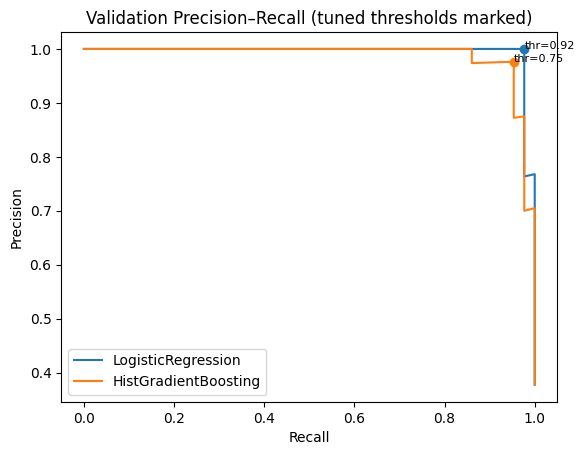

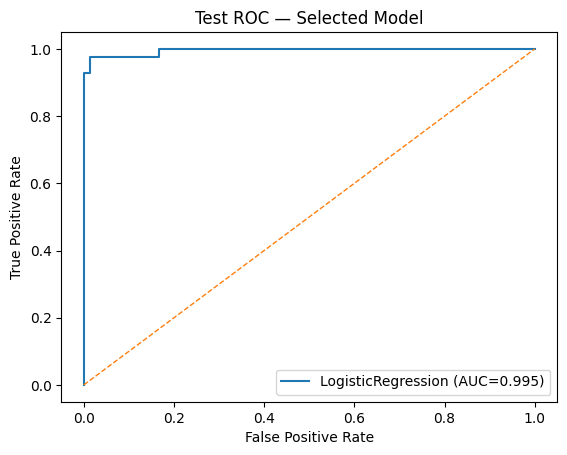

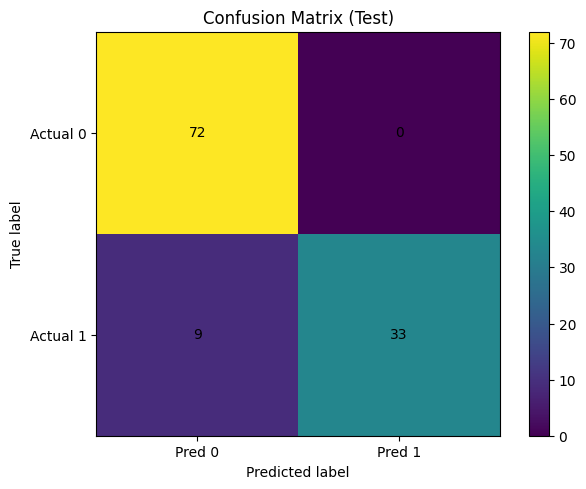

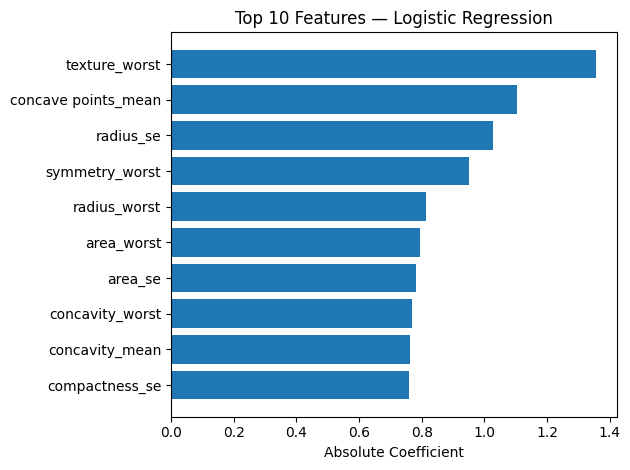

In [14]:
# === Visualizations (append to end of Cell 11) ===
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
import numpy as np

# 0) Collect per-model tuned thresholds; recompute if res_df is missing
thr_map = {}
if 'res_df' in globals():
    thr_map = {m: float(t) for m, t in zip(res_df['model'], res_df['best_thr'])}
else:
    thr_map = {}
    for name, proba in VAL_PROBA.items():
        pr, rc, th = precision_recall_curve(y_val, proba)
        p = pr[:-1]; r = rc[:-1]
        f1 = 2 * p * r / (p + r + 1e-12)
        max_f1 = f1.max()
        cand_idx = np.where(np.isclose(f1, max_f1))[0]
        best_idx = cand_idx[np.argmax(r[cand_idx])]
        thr_map[name] = float(th[best_idx])

# 1) Validation Precision–Recall curves (both models) + tuned-threshold markers
plt.figure()
for name, proba in VAL_PROBA.items():
    pr, rc, th = precision_recall_curve(y_val, proba)
    plt.plot(rc, pr, label=f"{name}")
    if name in thr_map and len(th) > 0:
        p = pr[:-1]; r = rc[:-1]
        idx = np.argmin(np.abs(th - thr_map[name]))
        plt.scatter(r[idx], p[idx], marker='o')
        plt.text(r[idx], p[idx], f"thr={thr_map[name]:.2f}", fontsize=8)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision–Recall (tuned thresholds marked)")
plt.legend()
plt.show()

# 2) Test ROC curve for the selected model
proba_test = BEST_PIPELINE.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"{BEST_MODEL_NAME} (AUC={roc:.3f})")
plt.plot([0, 1], [0, 1], '--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC — Selected Model")
plt.legend()
plt.show()

# 3) Test Confusion Matrix at tuned threshold
cm = confusion_matrix(y_test, (proba_test >= BEST_THRESHOLD).astype(int))
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Pred 0", "Pred 1"])
plt.yticks(tick_marks, ["Actual 0", "Actual 1"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# 4) Top features: LR absolute coefficients OR permutation importance for HGB
def _feature_names(pipeline, fallback):
    try:
        return pipeline.named_steps["pre"].get_feature_names_out().tolist()
    except Exception:
        return list(fallback)

feat_names = _feature_names(BEST_PIPELINE, FEATURES)

if BEST_MODEL_NAME == "LogisticRegression":
    coefs = BEST_PIPELINE.named_steps["clf"].coef_.ravel()
    top_idx = np.argsort(np.abs(coefs))[::-1][:10]
    plt.figure()
    plt.barh([feat_names[i] for i in top_idx][::-1], np.abs(coefs[top_idx])[::-1])
    plt.xlabel("Absolute Coefficient")
    plt.title("Top 10 Features — Logistic Regression")
    plt.tight_layout()
    plt.show()
else:
    # HistGradientBoosting: permutation importance (AUC-based) on TEST
    from sklearn.inspection import permutation_importance
    r = permutation_importance(
        BEST_PIPELINE, X_test, y_test,
        n_repeats=5, random_state=RANDOM_STATE, scoring="roc_auc"
    )
    imp = r.importances_mean
    top_idx = np.argsort(imp)[::-1][:10]
    plt.figure()
    plt.barh([feat_names[i] for i in top_idx][::-1], imp[top_idx][::-1])
    plt.xlabel("Permutation Importance (AUC drop)")
    plt.title("Top 10 Features — HistGradientBoosting")
    plt.tight_layout()
    plt.show()
